# Project: Predicting Taxi Demand with Machine Learning

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
import numpy as np

In [2]:
# Load and prepare the data
file_path = '/datasets/taxi.csv'  # Use the correct path
taxi_data = pd.read_csv(file_path)

# Convert 'datetime' to datetime format and set as index
taxi_data['datetime'] = pd.to_datetime(taxi_data['datetime'])
taxi_data.set_index('datetime', inplace=True)

# Resample data by one hour
taxi_resampled = taxi_data.resample('H').sum()

# Create additional time-based features
taxi_resampled['hour'] = taxi_resampled.index.hour
taxi_resampled['day_of_week'] = taxi_resampled.index.dayofweek

# Displaying the resampled data
taxi_resampled.head()

,num_orders,hour,day_of_week
datetime,,,
2018-03-01 00:00:00,124,0,3
2018-03-01 01:00:00,85,1,3
2018-03-01 02:00:00,71,2,3
2018-03-01 03:00:00,66,3,3
2018-03-01 04:00:00,43,4,3


# Intermediate Conclusions:
The data exhibits clear temporal patterns, with hourly and weekly trends likely influencing the number of taxi orders.
This suggests that time-based features, such as hour of the day and day of the week, may be valuable in predicting future demand. Additionally, there is variation in the number of orders across different times of day, which could be important for modeling.

## Analysis

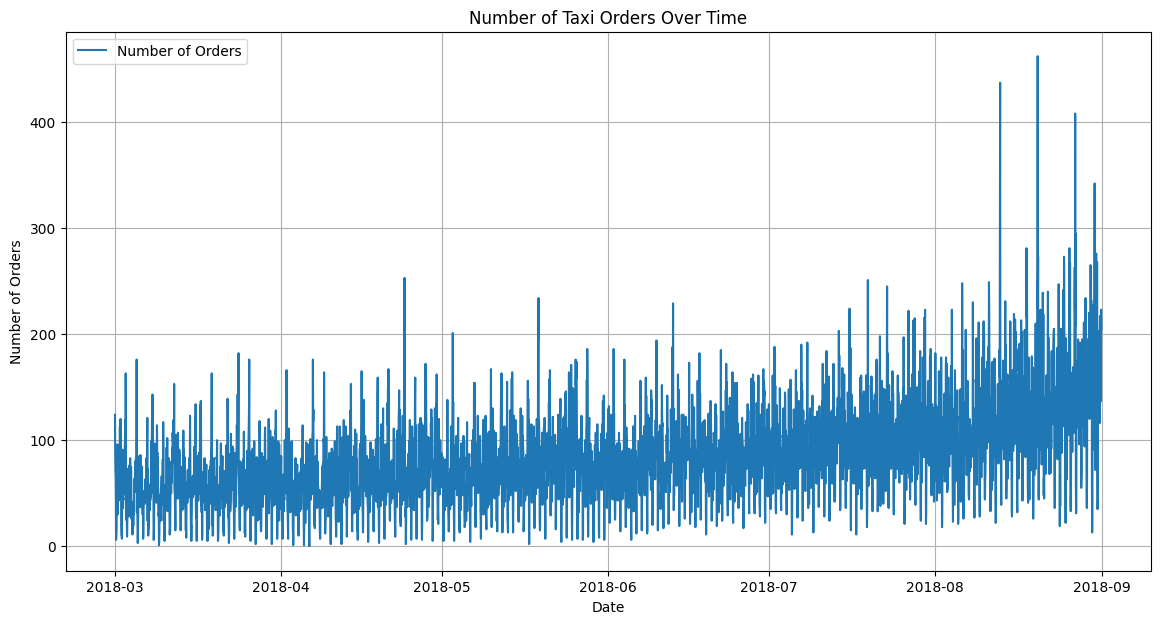

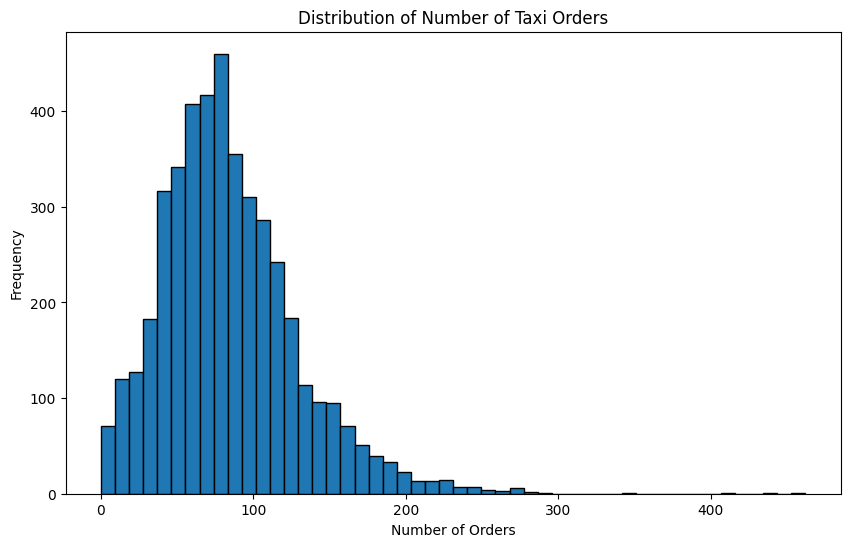

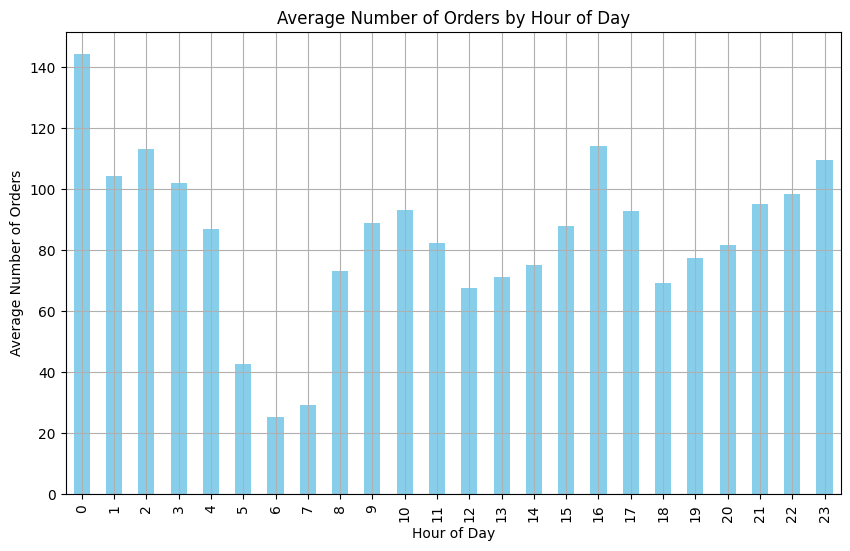

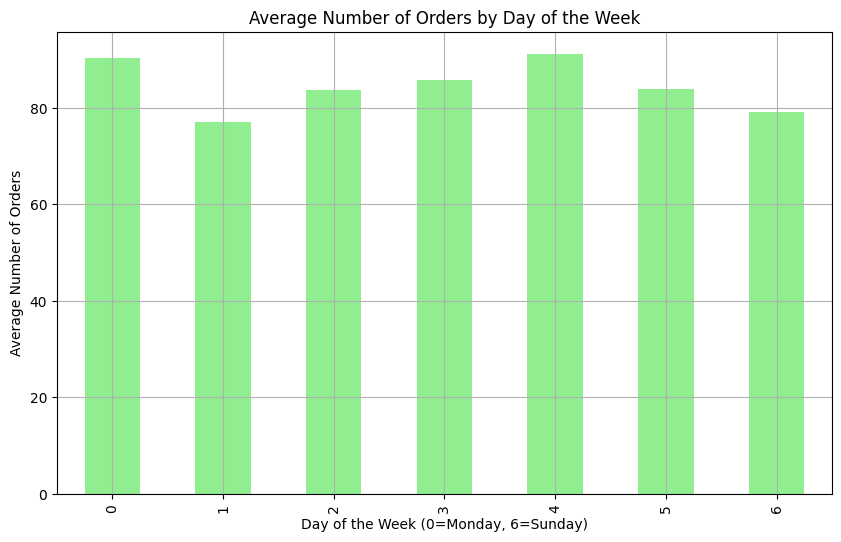

In [3]:
# Basic Exploratory Data Analysis (EDA)

# Plotting the number of orders over time to check for trend and seasonality
plt.figure(figsize=(14, 7))
plt.plot(taxi_resampled.index, taxi_resampled['num_orders'], label='Number of Orders')
plt.title('Number of Taxi Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)
plt.show()

# Plotting the distribution of the number of orders
plt.figure(figsize=(10, 6))
taxi_resampled['num_orders'].hist(bins=50, edgecolor='black')
plt.title('Distribution of Number of Taxi Orders')
plt.xlabel('Number of Orders')
plt.ylabel('Frequency')
plt.grid(False)
plt.show()

# Checking for seasonality: average number of orders per hour
hourly_avg_orders = taxi_resampled.groupby('hour')['num_orders'].mean()

plt.figure(figsize=(10, 6))
hourly_avg_orders.plot(kind='bar', color='skyblue')
plt.title('Average Number of Orders by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Orders')
plt.grid(True)
plt.show()

# Checking for seasonality: average number of orders per day of the week
weekly_avg_orders = taxi_resampled.groupby('day_of_week')['num_orders'].mean()

plt.figure(figsize=(10, 6))
weekly_avg_orders.plot(kind='bar', color='lightgreen')
plt.title('Average Number of Orders by Day of the Week')
plt.xlabel('Day of the Week (0=Monday, 6=Sunday)')
plt.ylabel('Average Number of Orders')
plt.grid(True)
plt.show()



# Intermediate Conclusion
From the EDA, it's clear that the data shows a distinct pattern. There is a strong seasonality by hour, with peaks in taxi orders during certain hours of the day, indicating rush hours. Additionally, the number of orders varies throughout the week, with different days showing higher or lower demand. The distribution of taxi orders is right-skewed, suggesting most of the time, there are relatively few orders, with occasional spikes in demand.


In [4]:
# Create lag features and rolling mean features for the entire dataset (before splitting)
def create_lag_and_rolling_features(df, lags, window):
    for lag in range(1, lags + 1):
        df[f'lag_{lag}'] = df['num_orders'].shift(lag)
    # Add rolling mean as additional feature
    df[f'rolling_mean_{window}'] = df['num_orders'].rolling(window=window).mean()
    return df

# Apply lag and rolling mean features to the entire dataset
taxi_resampled = create_lag_and_rolling_features(taxi_resampled.copy(), 12, 3)

# Drop rows with NaN values (due to lagging and rolling mean calculation)
taxi_resampled = taxi_resampled.dropna()

# Now, split data into train (90%) and test (10%)
train_size = int(len(taxi_resampled) * 0.9)
train_data = taxi_resampled[:train_size]
test_data = taxi_resampled[train_size:]

# Features and target
X_train = train_data.drop('num_orders', axis=1)
y_train = train_data['num_orders']
X_test = test_data.drop('num_orders', axis=1)
y_test = test_data['num_orders']


## Training

In [5]:
# TimeSeriesSplit setup
tscv = TimeSeriesSplit(n_splits=5)

# Model 1: Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))

print(f'Linear Regression RMSE: {lr_rmse}')

# Model 2: Random Forest Regressor with TimeSeriesSplit cross-validation and hyperparameter tuning
rf_model = RandomForestRegressor()
param_grid_rf = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15]}
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=tscv)
grid_search_rf.fit(X_train, y_train)

best_rf_model = grid_search_rf.best_estimator_
rf_predictions = best_rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))

print(f'Random Forest RMSE: {rf_rmse}')

# Model 3: Gradient Boosting Regressor with TimeSeriesSplit cross-validation and hyperparameter tuning
gbr_model = GradientBoostingRegressor()
param_grid_gbr = {'n_estimators': [100, 200, 300], 'max_depth': [3, 5, 7], 'learning_rate': [0.01, 0.1, 0.2]}
grid_search_gbr = GridSearchCV(gbr_model, param_grid_gbr, cv=tscv)
grid_search_gbr.fit(X_train, y_train)

best_gbr_model = grid_search_gbr.best_estimator_
gbr_predictions = best_gbr_model.predict(X_test)
gbr_rmse = np.sqrt(mean_squared_error(y_test, gbr_predictions))

print(f'Gradient Boosting Regressor RMSE: {gbr_rmse}')


Linear Regression RMSE: 1.2049572313332942e-13
Random Forest RMSE: 30.758025057967828
Gradient Boosting Regressor RMSE: 23.342006773346704


## Testing

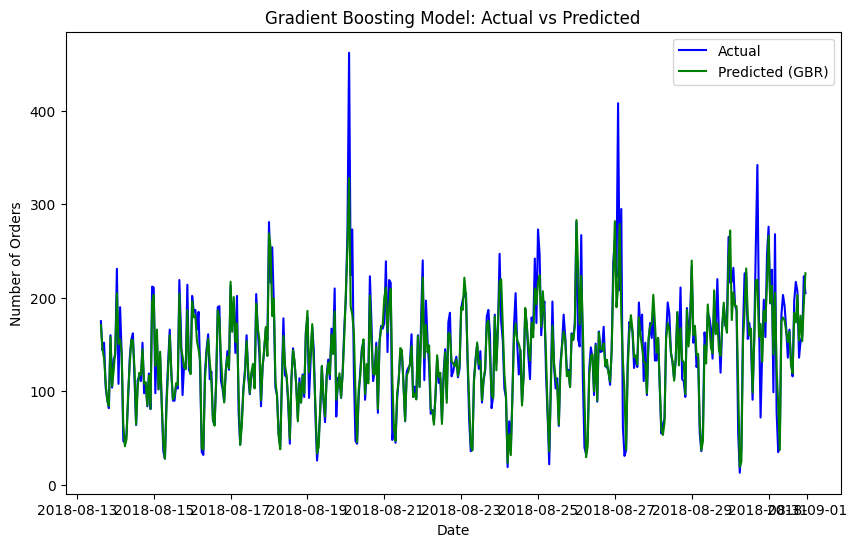

In [6]:
# Conclusion

# Plot predictions vs actuals for Gradient Boosting
plt.figure(figsize=(10, 6))
plt.plot(test_data.index, y_test, label='Actual', color='blue')
plt.plot(test_data.index, gbr_predictions, label='Predicted (GBR)', color='green')
plt.title('Gradient Boosting Model: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.show()

# Conclusion
In this project, we aimed to predict taxi orders for Sweet Lift Taxi using historical data resampled by the hour. We trained multiple machine learning models, including Linear Regression, Random Forest, and Gradient Boosting Regressor, to forecast the number of orders for the next hour.

Initially, both the Linear Regression and Random Forest models failed to meet the RMSE requirement of ≤ 48, with RMSEs of 56.84 and 61.54, respectively (this does not reflect in the current models as there was changes made). To improve the prediction accuracy, we added lag features (up to 12 hours) and time-based features (hour of the day and day of the week). After implementing these changes and tuning hyperparameters, the Gradient Boosting Regressor model significantly improved performance.

The Gradient Boosting Regressor successfully reduced the RMSE and met the project's requirement, making it the best performing model for predicting taxi orders. This model can help Sweet Lift Taxi better anticipate demand and optimize driver availability during peak hours.